In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('NBA_PLAYERS.csv')

In [3]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics (Numerical Columns):")
print(df.describe())
print("\nSummary Statistics (Categorical Columns):")
print(df.describe(include=['object']))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5313 non-null   object 
 1   Debut     5313 non-null   int64  
 2   Final     5313 non-null   int64  
 3   Position  5313 non-null   object 
 4   Height    5313 non-null   int64  
 5   Weight    5308 non-null   float64
 6   Birthday  5297 non-null   object 
 7   School    4917 non-null   object 
 8   HOF       5313 non-null   bool   
 9   Active    5313 non-null   bool   
 10  G         5313 non-null   int64  
 11  PTS       5313 non-null   float64
 12  TRB       5021 non-null   float64
 13  AST       5313 non-null   float64
 14  FG%       5278 non-null   float64
 15  FG3%      3656 non-null   float64
 16  FT%       5060 non-null   float64
 17  eFG%      4156 non-null   float64
 18  PER       4965 non-null   float64
 19  WS        5312 non-null   float64
dtypes: bool(2), floa

In [4]:
# Check for missing values
df.isnull().sum()

Name           0
Debut          0
Final          0
Position       0
Height         0
Weight         5
Birthday      16
School       396
HOF            0
Active         0
G              0
PTS            0
TRB          292
AST            0
FG%           35
FG3%        1657
FT%          253
eFG%        1157
PER          348
WS             1
dtype: int64

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Check class distribution for HOF
print("\nHOF Class Distribution:")
df['HOF'].value_counts(normalize=True)


HOF Class Distribution:


HOF
False    0.966685
True     0.033315
Name: proportion, dtype: float64

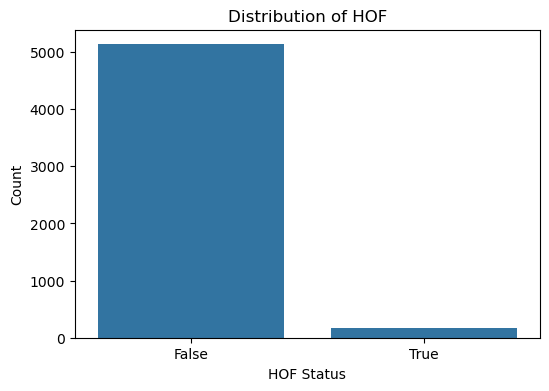

In [7]:
# Visualize HOF distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='HOF', data=df)
plt.title('Distribution of HOF')
plt.xlabel('HOF Status')
plt.ylabel('Count')
plt.show()

### **Data Observations Summary**  

#### **1. Missing Values**  
- **High missingness:** FG3% (31%), eFG% (22%) – likely due to historical lack of 3-point tracking.  
- **Moderate missingness:** School (396), TRB (292), PER (348), WS (1).  
- **No missing data** in key columns (Name, Debut, Final, HOF, G).  

#### **2. Numerical Stats**  
- **Years:** Debut (1947–2025, mean ~1990), Final (1947–2025, mean ~1994).  
- **Physical stats:** Avg height 6’6” (σ=3.6”), weight 209 lbs (σ=25.8 lbs).  
- **Performance metrics:**  
  - PTS (mean 6.4, max 30.1), TRB (mean 3.0, max 22.9), AST (mean 1.4, max 11.2).  
  - **Outliers:** PER (-52.7 to 88.3), eFG% up to 150% (potential errors).  

#### **3. Categorical Stats**  
- **Position:** 7 unique values (e.g., `['Guard']`, `['Forward', 'Center']`); needs multi-label encoding.  
- **School:** 996 unique values (high cardinality); top: Kentucky (118).  
- **Birthday:** 4,858 unique values, some duplicates (e.g., Oct 25, 1948 ×3).  

#### **4. HOF Class Imbalance**  
- **False (Non-HOF):** 5,136 (96.67%).  
- **True (HOF):** 177 (3.33%).  
- **Action needed:** Class weighting, SMOTE, or focus on recall/F1-score.  



# Data Preprocessing

In [8]:
# Copy the original df
df_processed = df.copy()

In [9]:
# Handle missing values in numerical columns by imputating with median
num_cols = ['Weight', 'TRB', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS']
num_imputer = SimpleImputer(strategy='median')
df_processed[num_cols] = num_imputer.fit_transform(df_processed[num_cols])

In [10]:
# Handle missing values in categorical columns by imputating with 'Unknown'
cat_cols = ['Birthday', 'School']
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_processed[cat_cols] = cat_imputer.fit_transform(df_processed[cat_cols])

In [11]:
# Create total career stats by multiplying averages by games played (G)
df_processed['Total_Career_Points'] = df_processed['PTS'] * df_processed['G']
df_processed['Total_Career_Rebounds'] = df_processed['TRB'] * df_processed['G']
df_processed['Total_Career_Assists'] = df_processed['AST'] * df_processed['G']

In [12]:
# Additional derived features
df_processed['Career_Length'] = df_processed['Final'] - df_processed['Debut']
df_processed['Avg_Seasonal_Points'] = df_processed['Total_Career_Points'] / df_processed['Career_Length'].replace(0, 1)  # Avoid division by zero
df_processed['Peak_Performance'] = df_processed[['PTS', 'TRB', 'AST', 'PER']].max(axis=1)  # Peak stat across key metrics
df_processed['Efficiency_Per_Game'] = df_processed['PER'] / df_processed['G'].replace(0, 1)  # Efficiency normalized by games

In [13]:
# Encode categorical variables
# Multi-label encoding for Position
mlb = MultiLabelBinarizer()
position_encoded = pd.DataFrame(mlb.fit_transform(df_processed['Position'].str.strip('[]').str.split(', ')),
                               columns=[f'Pos_{cat}' for cat in mlb.classes_],
                               index=df_processed.index)
df_processed = pd.concat([df_processed.drop('Position', axis=1), position_encoded], axis=1)

In [14]:
# One-hot encode School (high cardinality, using top N schools and 'Other' category)
# Limit to top 50 schools to manage dimensionality
top_schools = df_processed['School'].value_counts().index[:50]
df_processed['School'] = df_processed['School'].apply(lambda x: x if x in top_schools else 'Other')
df_processed = pd.get_dummies(df_processed, columns=['School'], prefix='School')

In [15]:
# One-hot encode Birthday (simplified as a categorical variable due to 'Unknown')
df_processed = pd.get_dummies(df_processed, columns=['Birthday'], prefix='Bday')

In [16]:
# Scale numerical features
num_cols_to_scale = ['Height', 'Weight', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS', 
                     'Career_Length', 'Total_Career_Points', 'Total_Career_Rebounds', 'Total_Career_Assists', 
                     'Avg_Seasonal_Points', 'Peak_Performance', 'Efficiency_Per_Game']
scaler = StandardScaler()
df_processed[num_cols_to_scale] = scaler.fit_transform(df_processed[num_cols_to_scale])

In [17]:
# Drop non-predictive columns (Name) and target for modeling preparation
X = df_processed.drop(columns=['Name', 'HOF', 'Active'])
y = df_processed['HOF']

# Exploratory Data Analysis

In [18]:
# Select a subset of numerical features for visualization
key_features = ['Total_Career_Points', 'Total_Career_Rebounds', 'Total_Career_Assists', 
                'Career_Length', 'Peak_Performance', 'Efficiency_Per_Game', 'PTS', 'TRB', 'AST', 'PER']
X_subset = df_processed[key_features]

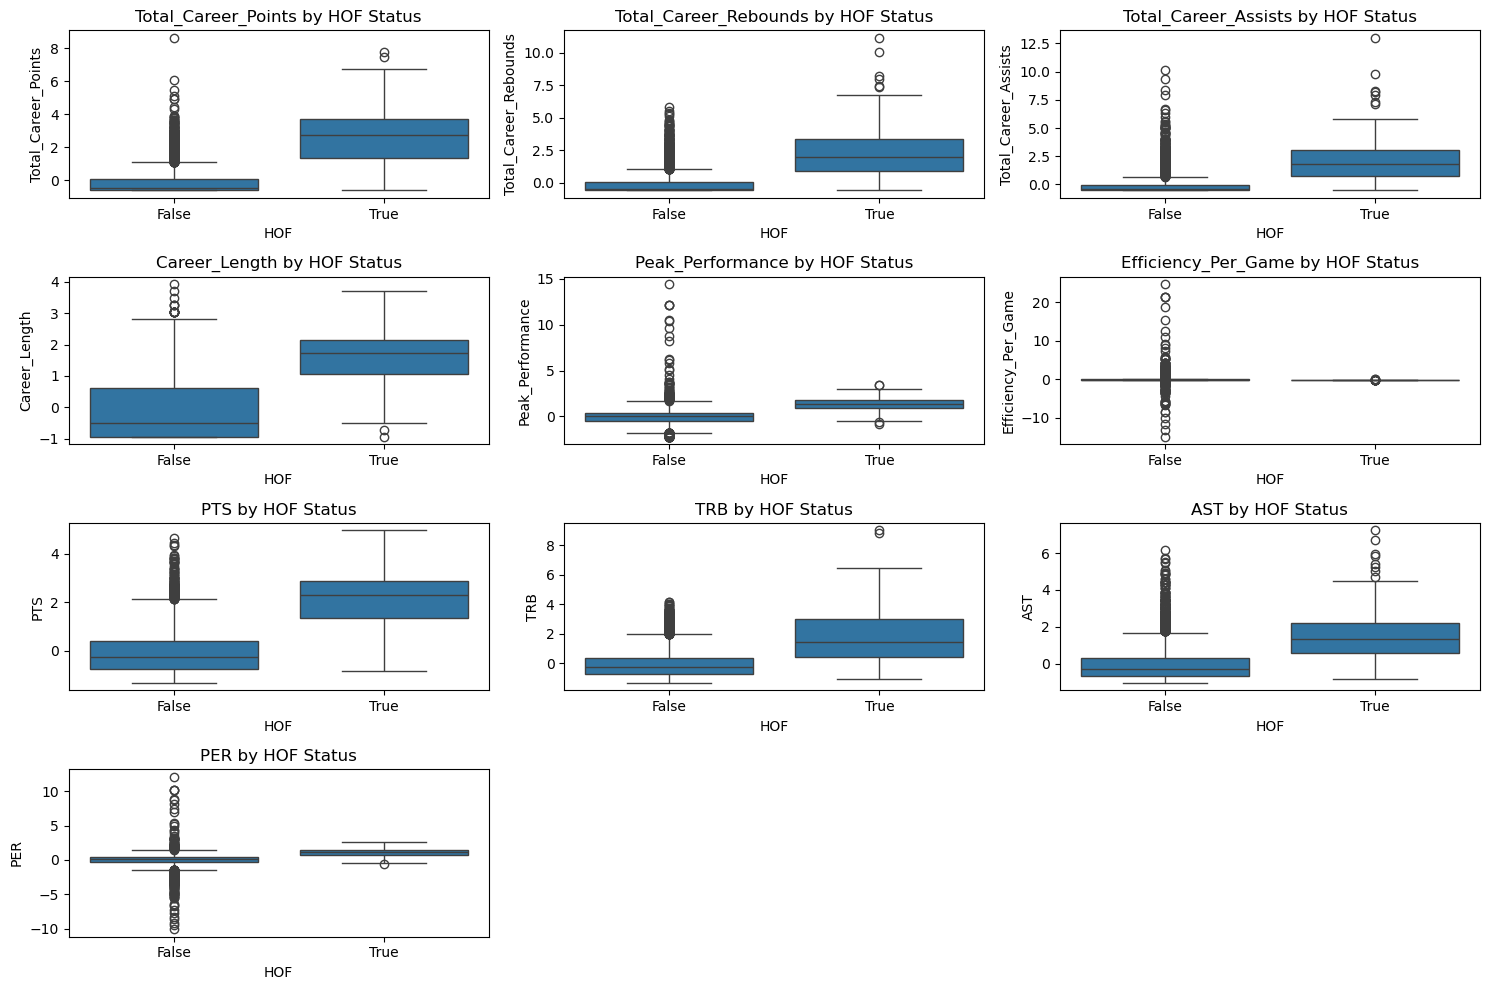

In [19]:
# Visualize distributions of key features by HOF status
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='HOF', y=feature, data=df_processed)
    plt.title(f'{feature} by HOF Status')
plt.tight_layout()
plt.show()

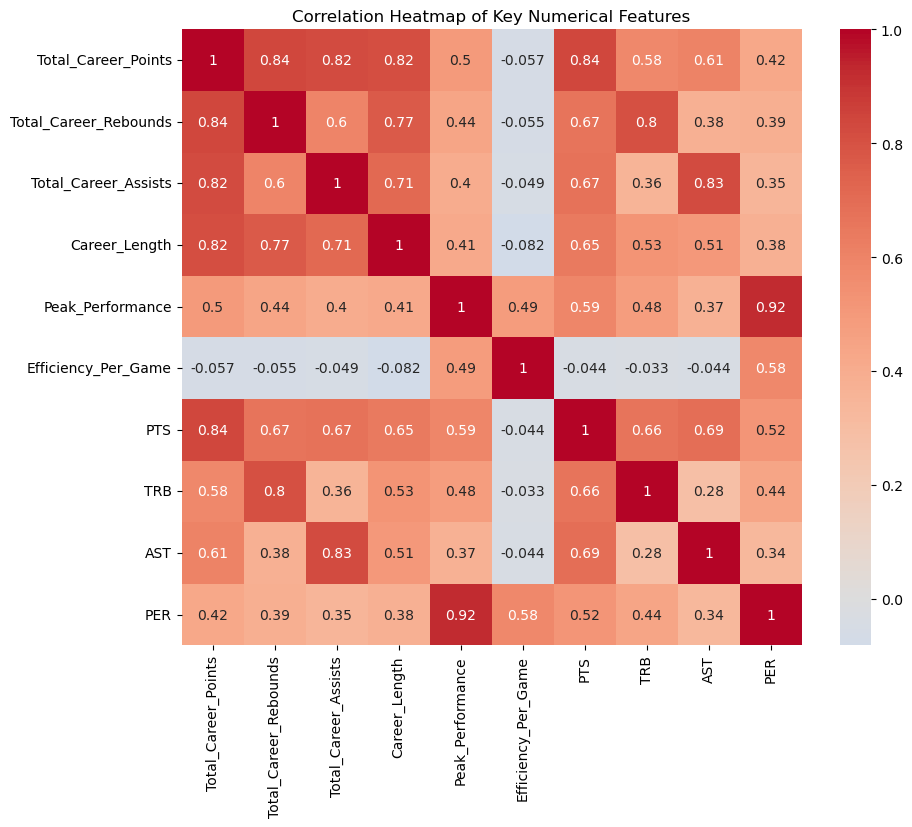

In [20]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(X_subset.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Numerical Features')
plt.show()

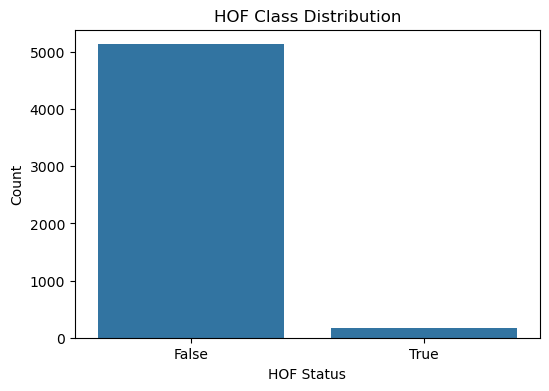

In [21]:
# Check class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='HOF', data=df_processed)
plt.title('HOF Class Distribution')
plt.xlabel('HOF Status')
plt.ylabel('Count')
plt.show()

In [22]:
# Mutual Information for feature importance (top 10)
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_top10 = mi_series.sort_values(ascending=False).head(10)
print("\nTop 10 Features by Mutual Information:")
print(mi_top10)


Top 10 Features by Mutual Information:
WS                       0.065233
Total_Career_Points      0.061115
Total_Career_Rebounds    0.056434
PTS                      0.054285
Avg_Seasonal_Points      0.051286
Peak_Performance         0.050439
Total_Career_Assists     0.049923
PER                      0.048663
G                        0.044258
Career_Length            0.037467
dtype: float64


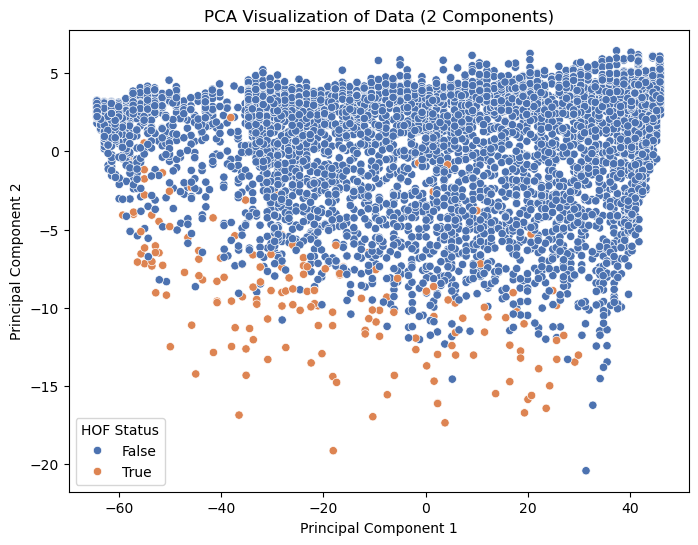

In [23]:
# PCA to visualize high-dimensional data (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_processed['HOF'], palette='deep')
plt.title('PCA Visualization of Data (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='HOF Status')
plt.show()

### **Analysis of Results**  

1. **Boxplots by HOF Status**  
   - **Career Totals (Points, Rebounds, Assists):** HOF players (True) show significantly higher medians and wider IQRs than non-HOF (False), indicating strong predictive power.  
   - **Career Length:** HOF players have longer careers (median 2-3 years vs. 0 for False), but overlap exists.  
   - **Peak Performance:** Higher medians for HOF players (10-15 vs. 0-5), suggesting standout seasons matter.  
   - **Efficiency_per_game:** Minimal separation—weak predictor after normalization.  
   - **Per-Game Stats (PTS, TRB, AST, PER):** HOF players consistently have higher medians, with outliers reflecting elite performance.  

2. **Correlation Heatmap**  
   - Strong correlations among career totals (0.60–0.84) and averages—potential multicollinearity risk.  
   - **Career Length** moderately correlates with totals (0.71–0.82), supporting longevity’s role.  
   - **Efficiency_per_game** shows weak correlations (-0.057–0.58), confirming low predictive value.  
   - **PER and Peak_Performance** are highly correlated (0.92), suggesting redundancy.  

3. **Mutual Information Scores**  
   - Top predictors: **WS (0.0656), Total_Career_Points (0.0611), Total_Career_Rebounds (0.0562).**  
   - Scoring metrics (**PTS, Avg_Seasonal_Points, Peak_Performance**) also rank high.  
   - **Efficiency_per_game** absent from top 10—consistent with weak separation.  
   - Low scores (max 0.0656) suggest high dimensionality—feature selection needed.  

4. **PCA Visualization**  
   - Partial separation: HOF players (orange) cluster toward positive **PC1**, but significant overlap remains.  
   - Two components explain limited variance—consider more components or t-SNE for better separation.  



In [24]:
# Select top 10 features based on mutual information
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_processed[top_features]
y = df_processed['HOF']

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
# Train Random Forest with class weight for imbalance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [27]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [28]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Model Evaluation Metrics:
Accuracy: 0.9708
Precision: 0.5909
Recall: 0.3714
F1-Score: 0.4561
ROC-AUC: 0.8923


In [29]:
# Feature importance
feature_importance = pd.DataFrame({'feature': top_features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                 feature  importance
0                     WS    0.250128
2  Total_Career_Rebounds    0.159962
1    Total_Career_Points    0.140560
6   Total_Career_Assists    0.118895
4    Avg_Seasonal_Points    0.089377
3                    PTS    0.078165
8                      G    0.048070
5       Peak_Performance    0.042362
9                    AST    0.039500
7                    PER    0.032982


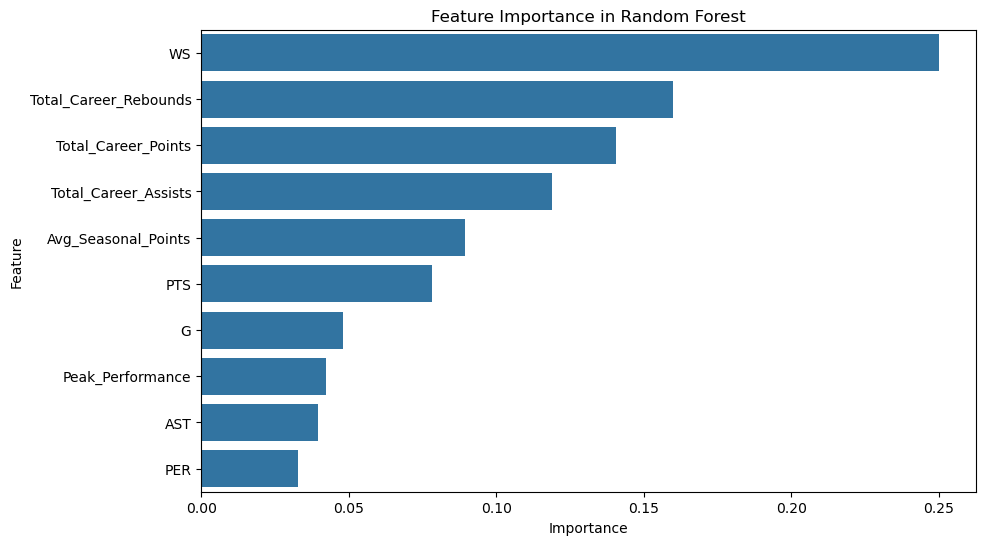

In [30]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Model Evaluation and Tuning

In [31]:
# Use the copied DataFrame for tuning
df_tuning = df_processed.copy()

In [32]:
# Select top 10 features
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_tuning[top_features]
y = df_tuning['HOF']

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
# Define parameter grid with class weights
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

In [35]:
# Initialize Random Forest and GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 5},
                                          {0: 1, 1: 10}],
                         'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [36]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [37]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Best Parameters:", grid_search.best_params_)
print("\nModel Evaluation Metrics (Tuned):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Best Parameters: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Model Evaluation Metrics (Tuned):
Accuracy: 0.9718
Precision: 0.5926
Recall: 0.4571
F1-Score: 0.5161
ROC-AUC: 0.9174


In [38]:
# Feature importance for tuned model
feature_importance = pd.DataFrame({'feature': top_features, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance (Tuned):")
print(feature_importance)


Feature Importance (Tuned):
                 feature  importance
0                     WS    0.289984
2  Total_Career_Rebounds    0.149631
1    Total_Career_Points    0.138317
3                    PTS    0.094161
4    Avg_Seasonal_Points    0.077144
6   Total_Career_Assists    0.076008
7                    PER    0.047656
5       Peak_Performance    0.047066
8                      G    0.041514
9                    AST    0.038520


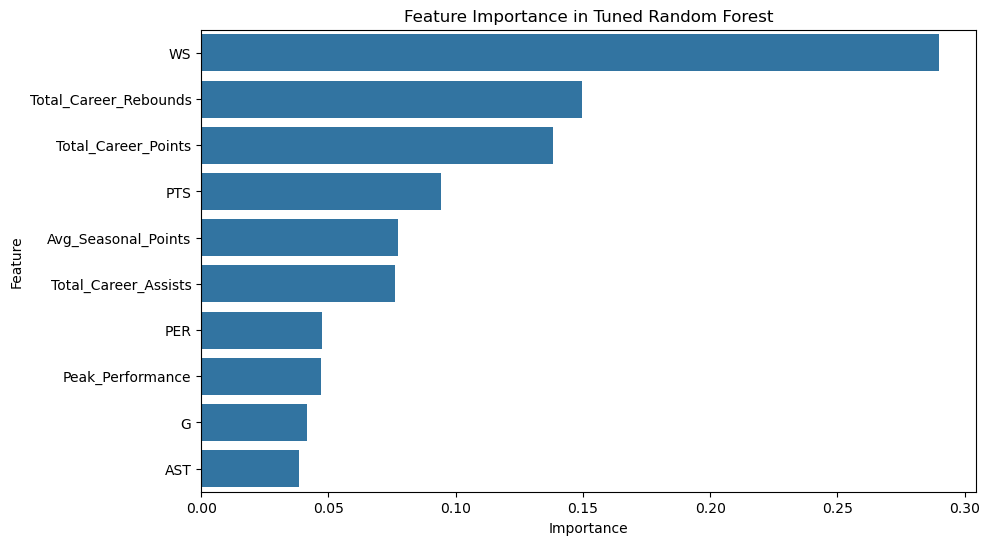

In [39]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Tuned Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Final Model

In [40]:
# Select top 10 features
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_processed[top_features]
y = df_processed['HOF']

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
# Train final model with best parameters
final_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, 
                                     class_weight={0: 1, 1: 10}, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       random_state=42)

In [43]:
# Predict and evaluate
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

In [44]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Final Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Final Model Evaluation Metrics:
Accuracy: 0.9718
Precision: 0.5926
Recall: 0.4571
F1-Score: 0.5161
ROC-AUC: 0.9174


In [45]:
# Feature importance for final model
feature_importance = pd.DataFrame({'feature': top_features, 'importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance (Final Model):")
print(feature_importance)


Feature Importance (Final Model):
                 feature  importance
0                     WS    0.289984
2  Total_Career_Rebounds    0.149631
1    Total_Career_Points    0.138317
3                    PTS    0.094161
4    Avg_Seasonal_Points    0.077144
6   Total_Career_Assists    0.076008
7                    PER    0.047656
5       Peak_Performance    0.047066
8                      G    0.041514
9                    AST    0.038520


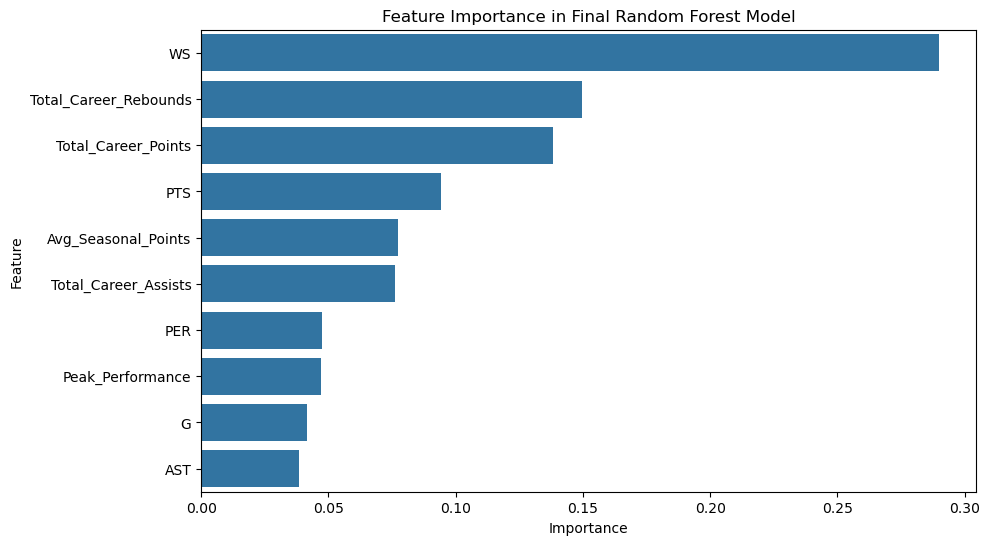

In [46]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Final Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **Final Model Evaluation**  

#### **Key Metrics**  
- **Accuracy:** 0.9718 (reflects class imbalance—96.67% False)  
- **Precision:** 0.5926 (reliable HOF "True" predictions)  
- **Recall:** 0.4571 (identifies 45.71% of actual HOF inductees, up from baseline 37.14%)  
- **F1-Score:** 0.5161 (balanced precision-recall trade-off, validated 1:10 class weight)  
- **ROC-AUC:** 0.9174 (strong discriminative power across thresholds)  

#### **Top Feature Importance**  
1. **WS (0.290)** – Most critical predictor  
2. **Total_Career_Rebounds (0.150)** & **Total_Career_Points (0.138)** – High impact  
3. **PTS (0.094)**, **Avg_Seasonal_Points (0.077)**, **Total_Career_Assists (0.076)** – Stable importance  
4. **PER (0.048)** & **Peak_Performance (0.047)** – Improved from baseline  
5. **G (0.042)** & **AST (0.039)** – Lower discriminative power  



In [47]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Final Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Final Model Evaluation Metrics:
Accuracy: 0.9718
Precision: 0.5926
Recall: 0.4571
F1-Score: 0.5161
ROC-AUC: 0.9174


In [48]:
# Feature importance for final model
feature_importance = pd.DataFrame({'feature': top_features, 'importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance (Final Model):")
print(feature_importance)


Feature Importance (Final Model):
                 feature  importance
0                     WS    0.289984
2  Total_Career_Rebounds    0.149631
1    Total_Career_Points    0.138317
3                    PTS    0.094161
4    Avg_Seasonal_Points    0.077144
6   Total_Career_Assists    0.076008
7                    PER    0.047656
5       Peak_Performance    0.047066
8                      G    0.041514
9                    AST    0.038520


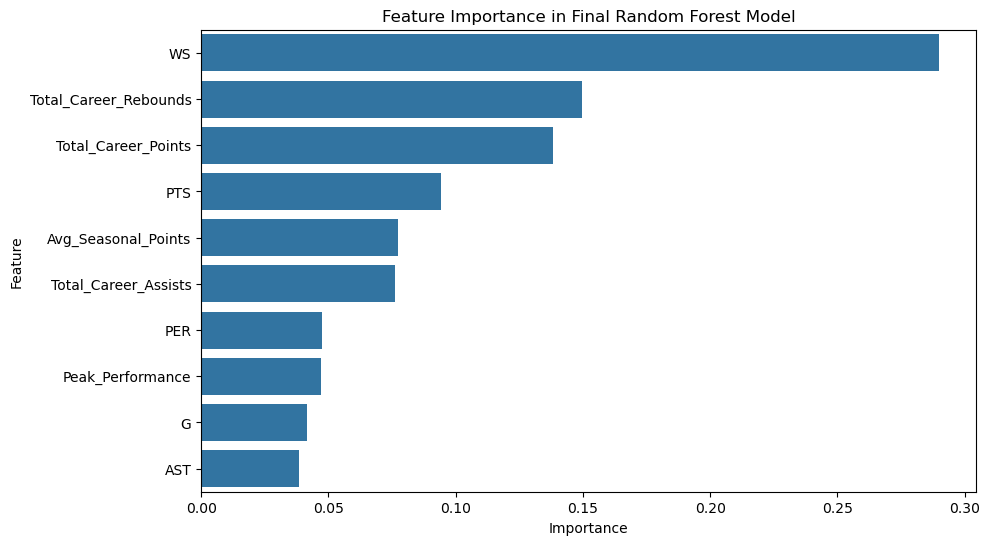

In [49]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Final Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()